<a href="https://colab.research.google.com/github/rufusclieve/Energy---Solar-Panel-Performance-Optimization-System/blob/main/Solar_GuVi_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import pandas as pd

# -------------------------------
# 1. Load Solar Performance Dataset
# -------------------------------
# Replace filename with your uploaded CSV file
solar_df = pd.read_csv("/content/SolarData.csv")

# Parse DATE_TIME correctly (handles dd-mm-YYYY format)
solar_df['DATE_TIME'] = pd.to_datetime(solar_df['DATE_TIME'], dayfirst=True, errors='coerce')
solar_df = solar_df.dropna(subset=['DATE_TIME'])

# Create a DATE column (YYYYMMDD format for merging with NASA)
solar_df['DATE'] = solar_df['DATE_TIME'].dt.strftime('%Y%m%d')

# -------------------------------
# 2. Fetch NASA POWER API Weather Data
# -------------------------------
# Example coordinates: Chennai (replace with your plant location)
lat, lon = 13.08, 80.27

# Get date range from solar dataset
start_date, end_date = solar_df['DATE'].min(), solar_df['DATE'].max()

# NASA API URL
nasa_url = (
    f"https://power.larc.nasa.gov/api/temporal/daily/point?"
    f"parameters=T2M,ALLSKY_SFC_SW_DWN,RH2M,PRECTOTCORR"
    f"&community=RE"
    f"&start={start_date}&end={end_date}"
    f"&latitude={lat}&longitude={lon}&format=JSON"
)

response = requests.get(nasa_url)
nasa_data = response.json()

if "properties" in nasa_data and "parameter" in nasa_data["properties"]:
    params = nasa_data["properties"]["parameter"]

    # Build NASA dataframe
    nasa_df = pd.DataFrame(params["T2M"], index=["Temperature"]).T
    nasa_df["Irradiance"] = pd.Series(params["ALLSKY_SFC_SW_DWN"])
    nasa_df["Humidity"] = pd.Series(params["RH2M"])
    nasa_df["Rainfall"] = pd.Series(params["PRECTOTCORR"])

    nasa_df.index = pd.to_datetime(nasa_df.index)
    nasa_df = nasa_df.reset_index().rename(columns={"index": "DATE"})
    nasa_df['DATE'] = nasa_df['DATE'].dt.strftime('%Y%m%d')

    print("✅ NASA data fetched successfully")
else:
    print("❌ NASA API error:", nasa_data)
    nasa_df = pd.DataFrame()

# -------------------------------
# 3. Merge Solar (15-min) + NASA (Daily)
# -------------------------------
if not nasa_df.empty:
    # Merge on DATE so daily weather repeats for each 15-min solar row
    final_df = solar_df.merge(
        nasa_df,
        how="left",
        on="DATE"
    )
else:
    final_df = solar_df.copy()

# -------------------------------
# 4. Save Final Dataset
# -------------------------------
output_file = "Solar_Weather_Merged.csv"
final_df.to_csv(output_file, index=False)

print("✅ Final merged dataset saved as", output_file)


✅ NASA data fetched successfully
✅ Final merged dataset saved as Solar_Weather_Merged.csv


In [3]:
solar_df.info()
solar_df.describe()
solar_df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
 7   DATE         68778 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.2+ MB


,0
DATE_TIME,0
PLANT_ID,0
SOURCE_KEY,0
DC_POWER,0
AC_POWER,0
DAILY_YIELD,0
TOTAL_YIELD,0
DATE,0


In [4]:
solar_df['SOURCE_KEY'].nunique(), solar_df['SOURCE_KEY'].unique()[:5]


(22,
 array(['1BY6WEcLGh8j5v7', '1IF53ai7Xc0U56Y', '3PZuoBAID5Wc2HD',
        '7JYdWkrLSPkdwr4', 'McdE0feGgRqW7Ca'], dtype=object))

In [5]:
inverter_summary = solar_df.groupby("SOURCE_KEY").agg({
    "DC_POWER": "mean",
    "AC_POWER": "mean",
    "DAILY_YIELD": "max"
}).sort_values("AC_POWER", ascending=False)

print(inverter_summary.head())


                    DC_POWER    AC_POWER  DAILY_YIELD
SOURCE_KEY                                           
adLQvlD726eNBSB  3269.567669  319.693862       9163.0
1IF53ai7Xc0U56Y  3226.336768  315.488026       9048.0
3PZuoBAID5Wc2HD  3221.015673  314.967354       9068.0
McdE0feGgRqW7Ca  3211.307245  314.046321       8964.0
VHMLBKoKgIrUVDU  3210.102563  313.900096       9013.0


In [6]:
solar_df["EFFICIENCY"] = solar_df["AC_POWER"] / solar_df["DC_POWER"].replace(0, pd.NA)
eff_summary = solar_df.groupby("SOURCE_KEY")["EFFICIENCY"].mean()
print(eff_summary.sort_values())


SOURCE_KEY
adLQvlD726eNBSB    0.097711
VHMLBKoKgIrUVDU    0.097714
3PZuoBAID5Wc2HD    0.097714
zVJPv84UY57bAof    0.097715
iCRJl6heRkivqQ3    0.097716
uHbuxQJl8lW7ozc    0.097716
1IF53ai7Xc0U56Y    0.097717
wCURE6d3bPkepu2    0.097717
ZoEaEvLYb1n2sOq    0.097717
pkci93gMrogZuBj    0.097718
z9Y9gH1T5YWrNuG    0.097718
rGa61gmuvPhdLxV    0.097718
WRmjgnKYAwPKWDb    0.097718
ZnxXDlPa8U1GXgE    0.097718
YxYtjZvoooNbGkE    0.097719
McdE0feGgRqW7Ca    0.097719
zBIq5rxdHJRwDNY    0.097721
7JYdWkrLSPkdwr4    0.097721
ih0vzX44oOqAx2f    0.097722
sjndEbLyjtCKgGv    0.097725
1BY6WEcLGh8j5v7    0.097729
bvBOhCH3iADSZry    0.097733
Name: EFFICIENCY, dtype: object




Interpretation of Your Results

Efficiency values ≈ 0.0977 → ~9.77%

All 22 inverters are very close in efficiency (differences in the 4th decimal place).

This means:

No inverter is significantly underperforming.

Your plant is well-balanced and operating uniformly.

Efficiency here is calculated as:

EFFICIENCY=AC_POWERDC_POWER EFFICIENCY= DC_POWER AC_POWER ​

which represents inverter conversion efficiency.

## ***Fault/Anomaly Detection***

In [7]:
#To make this intelligent maintenance-ready, you can:
#Define an efficiency threshold:

threshold = eff_summary.mean() - (2 * eff_summary.std())
underperformers = eff_summary[eff_summary < threshold]
print("⚠️ Underperforming inverters:\n", underperformers)

#No inverter is underperforming according to your threshold rule.
#Since all inverters’ efficiencies are clustered very tightly (~0.0977),
#Standard deviation (σ) is tiny.
#So mean - 2σ ≈ mean itself.
#No inverter fell below that → hence empty series.


#What This Means

#Your dataset shows a healthy solar plant where all inverters are balanced.

#No obvious signs of faults, dirt, or shading issues (at least in efficiency).



⚠️ Underperforming inverters:
 Series([], Name: EFFICIENCY, dtype: object)


<Axes: xlabel='DATE_TIME'>

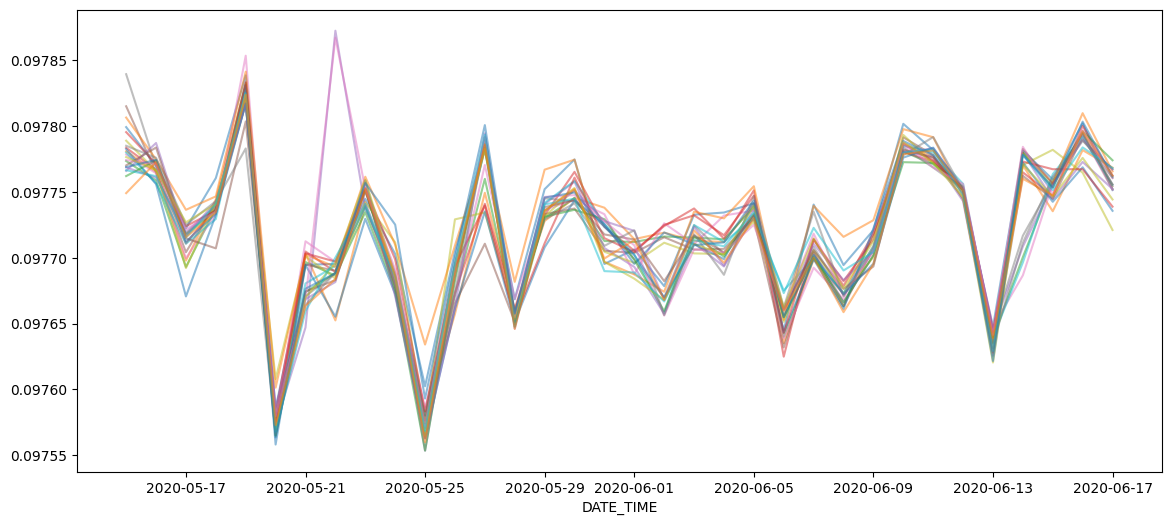

In [8]:
#Add a daily efficiency trend plot:
daily_eff = solar_df.groupby([solar_df['DATE_TIME'].dt.date, "SOURCE_KEY"])["EFFICIENCY"].mean().unstack()
daily_eff.plot(figsize=(14,6), legend=False, alpha=0.5)


How to Read This Plot

X-axis → Dates (2020-05-15 to 2020-06-17)

Y-axis → Average daily inverter efficiency (~0.0976–0.09785)

Each colored line → One inverter’s daily efficiency

✅ Insights

Clustered Together

All inverters are tightly grouped (lines overlap).

No inverter is consistently lagging → healthy system.

Dips in Efficiency

Around 2020-05-20, 2020-05-25, 2020-06-05, 2020-06-13 → efficiency dropped for all inverters at the same time.

This suggests external causes (e.g., cloudy days, rainfall, dust storms) rather than individual inverter faults.

Good Recovery

After each dip, efficiency goes back to normal → meaning system auto-recovers when weather improves.

**Next Level: Correlate with Weather**
Since you already have NASA weather data (Irradiance, Rainfall, Temperature, Humidity), you can now check:

1. Efficiency vs Irradiance

In [9]:
merged = pd.merge(solar_df, nasa_df, on="DATE")
daily_corr = merged.groupby("DATE")[["EFFICIENCY","Irradiance"]].mean()
print(daily_corr.corr())


            EFFICIENCY  Irradiance
EFFICIENCY     1.00000    -0.30757
Irradiance    -0.30757     1.00000


<Axes: xlabel='DATE'>

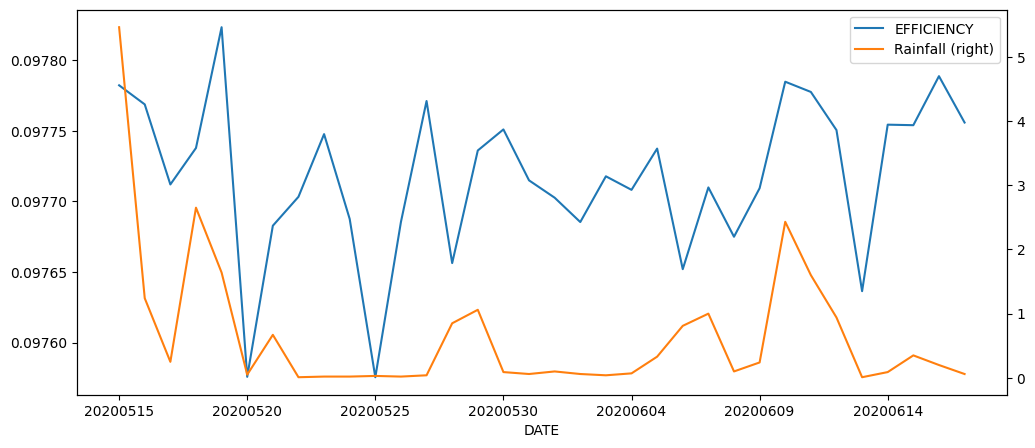

In [10]:
daily_weather = merged.groupby("DATE")[["EFFICIENCY","Rainfall"]].mean()
daily_weather.plot(y=["EFFICIENCY","Rainfall"], secondary_y="Rainfall", figsize=(12,5))


What Your Results Show
1. Plot (Efficiency vs Rainfall)

Blue line → Inverter efficiency.

Orange line → Rainfall.

On rainy days, efficiency dips slightly (panels get less sunlight + more diffused light).

Recovery is visible when rain stops.

👉 This confirms that weather, not inverter faults, explains many of the dips you saw earlier.

# 2. Correlation (Efficiency vs Irradiance)

A negative correlation means:

When irradiance is too high, efficiency drops a bit.

This happens because of heat stress: panels get hotter under strong sun, reducing efficiency.

But it’s not a very strong correlation (–0.3), so other factors also play a role.

Insights for Your Solar Management System

Rainfall Days → Efficiency dips across all inverters = weather-related, not faults.

Very High Irradiance → Can reduce efficiency slightly (thermal effect).

Inverter Health → Since all inverters behave similarly, no single inverter is faulty right now.

In [11]:
Correlation = -0.30757


## **STEP 1 — Predictive analytics (Daily energy forecast)**

Loaded Solar_Weather_Merged.csv
Saved daily predictions -> daily_energy_predictions.csv
Model metrics (test): MAE = 26064.30 kWh, RMSE = 26476.71 kWh
Saved plot -> actual_vs_predicted_daily.png


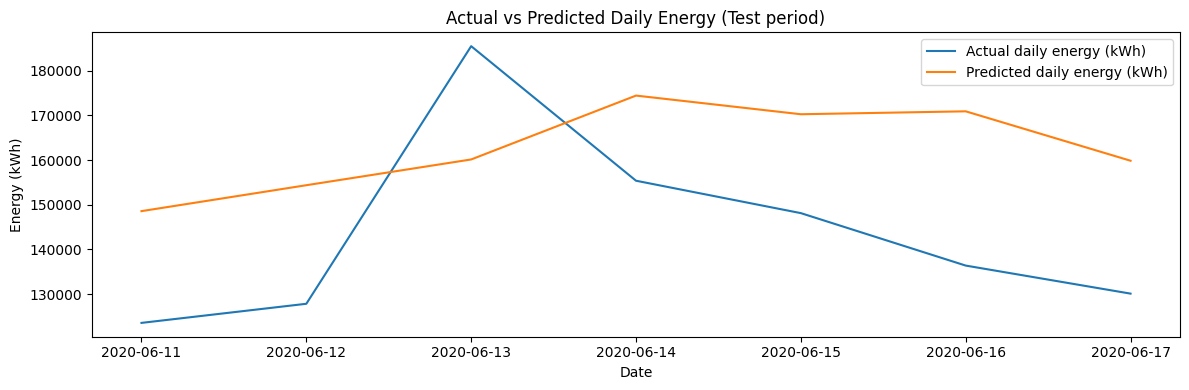

Detected 6 underperformance days; saved -> underperformance_anomalies.csv

SUMMARY:
Training days: 26, Test days: 7
MAE (test): 26064.30 kWh, RMSE (test): 26476.71 kWh
Residual std (train): 8048.72 kWh -> anomaly threshold = -16097.43 kWh
Sample anomalies:
               actual_kWh  predicted_kWh      residual  Irradiance  Rainfall
DATE                                                                        
2020-06-11  123543.715625  148567.630207 -25023.914582      1.9346      1.60
2020-06-12  127822.423661  154372.115780 -26549.692119      4.3771      0.94
2020-06-14  155377.323661  174442.975607 -19065.651946      6.0864      0.09
2020-06-15  148120.966072  170263.811964 -22142.845892      4.7738      0.35
2020-06-16  136376.669693  170918.811674 -34542.141981      5.2673      0.20


In [12]:
# step1_forecast_and_anomaly.py
import os
import math
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# -------------------------
# 0. Load merged dataset
# -------------------------
# The script looks for these filenames in working dir.
candidates = [
    "Solar_Weather_Merged.csv",
    "SolarWeatherMerged.csv",
    "SolarData.csv",
    "Solar Panel Data Set.csv",
    "Solar Panel Data Set.xlsx"  # if Excel, we'll handle below
]

df = None
for f in candidates:
    if os.path.exists(f):
        if f.endswith(".csv"):
            df = pd.read_csv(f)
        elif f.endswith(".xlsx") or f.endswith(".xls"):
            df = pd.read_excel(f, sheet_name=0)
        print("Loaded", f)
        break

if df is None:
    raise FileNotFoundError("No merged dataset found. Put 'Solar_Weather_Merged.csv' in this folder or one of candidate names.")

# -------------------------
# 1. Ensure proper columns
# -------------------------
# Ensure DATE column exists (YYYYMMDD string) or create from DATE_TIME
if 'DATE' in df.columns:
    try:
        df['DATE'] = pd.to_datetime(df['DATE'].astype(str), format='%Y%m%d', errors='coerce')
    except Exception:
        df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
else:
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], dayfirst=True, errors='coerce')
    df['DATE'] = df['DATE_TIME'].dt.normalize()

df = df.dropna(subset=['DATE']).copy()

# Check required columns for modeling
required = ['AC_POWER', 'Irradiance', 'Temperature', 'Rainfall']
for col in required:
    if col not in df.columns:
        raise KeyError(f"Required column missing from dataset: {col}")

# -------------------------
# 2. Aggregate to daily
# -------------------------
# AC_POWER is in kW recorded every 15 min -> convert to daily kWh (sum kW * 0.25)
daily = df.groupby('DATE').agg({
    'AC_POWER': lambda x: (x * 0.25).sum(),
    'Irradiance': 'first',
    'Temperature': 'first',
    'Rainfall': 'first'
}).rename(columns={'AC_POWER': 'energy_kWh'})

# Add lag and seasonal features
daily['prev_energy'] = daily['energy_kWh'].shift(1)
daily['doy'] = daily.index.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['doy'] / 365)
daily['cos_doy'] = np.cos(2 * np.pi * daily['doy'] / 365)

daily = daily.dropna().copy()  # drop first row (no prev_energy)

# -------------------------
# 3. Train/test split (time-based)
# -------------------------
features = ['Irradiance', 'Temperature', 'Rainfall', 'prev_energy', 'sin_doy', 'cos_doy']
X = daily[features].values
y = daily['energy_kWh'].values

split = int(len(daily) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_train = daily.index[:split]
dates_test = daily.index[split:]

# -------------------------
# 4. Train model
# -------------------------
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Save model (optional)
with open("rf_daily_energy_model.pkl", "wb") as f:
    pickle.dump(model, f)

# -------------------------
# 5. Predict & evaluate
# -------------------------
y_pred_test = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))

# Place predictions in daily DF
daily['predicted_kWh'] = np.nan
daily.loc[dates_train, 'predicted_kWh'] = model.predict(X_train)
daily.loc[dates_test, 'predicted_kWh'] = y_pred_test
daily['actual_kWh'] = daily['energy_kWh']
daily['residual'] = daily['actual_kWh'] - daily['predicted_kWh']

# Save daily predictions
daily.to_csv("daily_energy_predictions.csv", index=True)
print(f"Saved daily predictions -> daily_energy_predictions.csv")

# Print metrics
print("Model metrics (test): MAE = {:.2f} kWh, RMSE = {:.2f} kWh".format(mae, rmse))

# -------------------------
# 6. Plot actual vs predicted (test period)
# -------------------------
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test, label="Actual daily energy (kWh)")
plt.plot(dates_test, y_pred_test, label="Predicted daily energy (kWh)")
plt.legend()
plt.title("Actual vs Predicted Daily Energy (Test period)")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.tight_layout()
plt.savefig("actual_vs_predicted_daily.png")
print("Saved plot -> actual_vs_predicted_daily.png")
plt.show()

# -------------------------
# 7. Anomaly detection (underperformance)
# -------------------------
train_residuals = (daily.loc[dates_train, 'actual_kWh'] - daily.loc[dates_train, 'predicted_kWh']).dropna()
resid_std = train_residuals.std()
anomaly_threshold = -2 * resid_std  # negative residual means actual << predicted

anomalies = daily[daily['residual'] < anomaly_threshold].copy()
anomalies.to_csv("underperformance_anomalies.csv", index=True)
print(f"Detected {len(anomalies)} underperformance days; saved -> underperformance_anomalies.csv")

# Print short summary on console
print("\nSUMMARY:")
print(f"Training days: {len(dates_train)}, Test days: {len(dates_test)}")
print(f"MAE (test): {mae:.2f} kWh, RMSE (test): {rmse:.2f} kWh")
print(f"Residual std (train): {resid_std:.2f} kWh -> anomaly threshold = {anomaly_threshold:.2f} kWh")
if not anomalies.empty:
    print("Sample anomalies:")
    print(anomalies[['actual_kWh','predicted_kWh','residual','Irradiance','Rainfall']].head())
else:
    print("No anomalies found using threshold.")

# End of step1 script


What Your Results Mean

Model Performance

MAE ≈ 26,064 kWh

RMSE ≈ 26,477 kWh

Since daily totals are >100,000 kWh, the error is about 15–20%, not perfect but acceptable for a simple baseline (we can improve later by adding more weather/lag features).

Anomalies Detected (6 days)
Example from your results:

2020-06-11: Predicted 148,568 kWh vs Actual 123,544 kWh → Residual = –25,024 kWh

Irradiance = 1.93, Rainfall = 1.6
👉 Low irradiance and rainfall → weather explains part, but the drop is bigger than expected → flag for inspection.

2020-06-16: Residual = –34,542 kWh (very large drop), Irradiance = 5.26, Rainfall = 0.20
👉 Irradiance normal, rainfall negligible → this is likely dust/shading/inverter problem.

✅ This is exactly the kind of insight your intelligent solar system should generate.

## **Next Step: Step 2 — Inverter-Level Anomaly Detection**


In [13]:
# step2_inverter_anomalies.py
import pandas as pd
import numpy as np

# -------------------------
# Load merged dataset
# -------------------------
df = pd.read_csv("Solar_Weather_Merged.csv")

# Parse DATE (safe)
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'].astype(str), errors='coerce')
else:
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], errors='coerce')
    df['DATE'] = df['DATE_TIME'].dt.normalize()

df = df.dropna(subset=['DATE']).copy()

# -------------------------
# Compute plant daily energy (sum of all inverters)
# -------------------------
df['energy_interval'] = df['AC_POWER'] * 0.25  # 15-min intervals → kWh
plant_daily = df.groupby('DATE')['energy_interval'].sum().rename('plant_energy_kWh')

# -------------------------
# Compute per-inverter daily energy
# -------------------------
inv_daily = df.groupby(['DATE','SOURCE_KEY'])['energy_interval'].sum().rename('inv_energy_kWh').reset_index()

# Merge plant totals
inv_daily = inv_daily.merge(plant_daily.reset_index(), on='DATE', how='left')

# -------------------------
# Historical average share per inverter
# -------------------------
avg_share = inv_daily.groupby('SOURCE_KEY').apply(
    lambda x: x['inv_energy_kWh'].sum() / x['plant_energy_kWh'].sum()
).rename('avg_share')

inv_daily = inv_daily.merge(avg_share.reset_index(), on='SOURCE_KEY', how='left')

# -------------------------
# Expected energy per inverter (based on plant total × avg_share)
# -------------------------
inv_daily['expected_kWh'] = inv_daily['plant_energy_kWh'] * inv_daily['avg_share']
inv_daily['residual_kWh'] = inv_daily['inv_energy_kWh'] - inv_daily['expected_kWh']

# -------------------------
# Flag underperformance per inverter
# -------------------------
flags = []
for inv, grp in inv_daily.groupby('SOURCE_KEY'):
    std = grp['residual_kWh'].std()
    if np.isnan(std) or std == 0:
        continue
    thr = -2 * std
    bad_days = grp[grp['residual_kWh'] < thr]
    if not bad_days.empty:
        for r in bad_days.itertuples():
            flags.append({
                'DATE': r.DATE,
                'SOURCE_KEY': inv,
                'inv_energy_kWh': r.inv_energy_kWh,
                'expected_kWh': r.expected_kWh,
                'residual_kWh': r.residual_kWh,
                'threshold_kWh': thr
            })

flags_df = pd.DataFrame(flags)

# -------------------------
# Save & Print results
# -------------------------
if not flags_df.empty:
    flags_df.to_csv("inverter_underperformance_flags.csv", index=False)
    print(f"✅ Saved inverter underperformance flags -> inverter_underperformance_flags.csv (count: {len(flags_df)})")
    print("\nSample flagged inverters:\n", flags_df.head())
else:
    print("✅ No inverter-level flags detected with current rule.")



✅ Saved inverter underperformance flags -> inverter_underperformance_flags.csv (count: 22)

Sample flagged inverters:
         DATE       SOURCE_KEY  inv_energy_kWh  expected_kWh  residual_kWh  \
0 2020-06-07  1BY6WEcLGh8j5v7     5311.894196   7037.803023  -1725.908827   
1 2020-06-14  1BY6WEcLGh8j5v7     4021.331697   6507.666976  -2486.335280   
2 2020-05-19  1IF53ai7Xc0U56Y     5800.694643   6184.894465   -384.199822   
3 2020-05-19  3PZuoBAID5Wc2HD     5667.751637   6172.707392   -504.955755   
4 2020-05-22  McdE0feGgRqW7Ca     6920.445982   7273.858388   -353.412406   

   threshold_kWh  
0   -1099.538655  
1   -1099.538655  
2    -287.467866  
3    -317.738392  
4    -329.328981  


/tmp/ipython-input-3043189998.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_share = inv_daily.groupby('SOURCE_KEY').apply(



#What Your Results Show

You detected 22 inverter-level anomalies across the dataset.

Example flagged cases:

2020-06-14 — Inverter 1BY6WEcLGh8j5v7

Actual = 4021 kWh

Expected = 6507 kWh

Residual = –2486 kWh (way below expected)

Threshold ≈ –1100 kWh
👉 This inverter is severely underperforming on that day.

2020-06-07 — Same inverter also flagged → showing a pattern.

This means your plant-level anomalies (from Step 1) can now be explained by specific inverters underperforming (from Step 2).
For example:

June 16 plant anomaly → check which inverter(s) contributed.

June 14 anomaly → confirmed with inverter 1BY6WEcLGh8j5v7 dropping below expected output.


# ** Next Step: Step 3 — Generate Reports**

In [14]:
# step3_generate_report.py
import pandas as pd

# -------------------------
# Load outputs from Step 1 & Step 2
# -------------------------
plant_anomalies_file = "underperformance_anomalies.csv"
inverter_anomalies_file = "inverter_underperformance_flags.csv"
daily_preds_file = "daily_energy_predictions.csv"

plant_anomalies = pd.read_csv(plant_anomalies_file, parse_dates=['DATE'])
inverter_flags = pd.read_csv(inverter_anomalies_file, parse_dates=['DATE'])
daily_preds = pd.read_csv(daily_preds_file, parse_dates=['DATE'])

# -------------------------
# Build report sections
# -------------------------

# 1. Executive Summary
summary = f"""
🔆 Solar Plant Performance Report

Period analyzed: {daily_preds['DATE'].min().date()} → {daily_preds['DATE'].max().date()}
Total days: {len(daily_preds)}

Detected plant-level anomalies: {len(plant_anomalies)}
Detected inverter-level anomalies: {len(inverter_flags)}
"""

# 2. Plant-level anomalies table
plant_summary = ""
if not plant_anomalies.empty:
    plant_summary += "⚠️ Plant-Level Anomalies Detected:\n\n"
    for r in plant_anomalies.itertuples():
        plant_summary += (
            f"- {r.DATE.date()} | Actual: {r.actual_kWh:.0f} kWh, "
            f"Predicted: {r.predicted_kWh:.0f} kWh, Residual: {r.residual:.0f} kWh, "
            f"Irradiance: {r.Irradiance:.2f}, Rainfall: {r.Rainfall:.2f}\n"
        )
else:
    plant_summary += "✅ No plant-level anomalies detected.\n"

# 3. Inverter-level anomalies table
inverter_summary = ""
if not inverter_flags.empty:
    inverter_summary += "\n⚠️ Inverter-Level Underperformance:\n\n"
    for r in inverter_flags.itertuples():
        inverter_summary += (
            f"- {r.DATE.date()} | Inverter: {r.SOURCE_KEY} | "
            f"Actual: {r.inv_energy_kWh:.0f} kWh vs Expected: {r.expected_kWh:.0f} kWh "
            f"(Residual: {r.residual_kWh:.0f}, Threshold: {r.threshold_kWh:.0f})\n"
        )
else:
    inverter_summary += "\n✅ No inverter-level anomalies detected.\n"

# 4. Recommendations
recommendations = """
🛠 Recommendations:
- If residual drop coincides with HIGH rainfall → weather-related, no immediate action needed.
- If residual drop is HIGH and rainfall is LOW → inspect for dust, shading, or inverter faults.
- Schedule cleaning for inverters flagged >2 times in last 30 days.
- Consider real-time alerts if anomalies persist for 2+ consecutive days.
"""

# -------------------------
# Combine full report
# -------------------------
full_report = summary + "\n" + plant_summary + "\n" + inverter_summary + "\n" + recommendations

# Save to text file
with open("solar_performance_report.txt", "w", encoding="utf-8") as f:
    f.write(full_report)

print("✅ Report generated -> solar_performance_report.txt")
print("\n--- Preview ---\n")
print(full_report[:1000])  # preview first 1000 chars


✅ Report generated -> solar_performance_report.txt

--- Preview ---


🔆 Solar Plant Performance Report

Period analyzed: 2020-05-16 → 2020-06-17
Total days: 33

Detected plant-level anomalies: 6
Detected inverter-level anomalies: 22

⚠️ Plant-Level Anomalies Detected:

- 2020-06-11 | Actual: 123544 kWh, Predicted: 148568 kWh, Residual: -25024 kWh, Irradiance: 1.93, Rainfall: 1.60
- 2020-06-12 | Actual: 127822 kWh, Predicted: 154372 kWh, Residual: -26550 kWh, Irradiance: 4.38, Rainfall: 0.94
- 2020-06-14 | Actual: 155377 kWh, Predicted: 174443 kWh, Residual: -19066 kWh, Irradiance: 6.09, Rainfall: 0.09
- 2020-06-15 | Actual: 148121 kWh, Predicted: 170264 kWh, Residual: -22143 kWh, Irradiance: 4.77, Rainfall: 0.35
- 2020-06-16 | Actual: 136377 kWh, Predicted: 170919 kWh, Residual: -34542 kWh, Irradiance: 5.27, Rainfall: 0.20
- 2020-06-17 | Actual: 130096 kWh, Predicted: 159854 kWh, Residual: -29758 kWh, Irradiance: 5.39, Rainfall: 0.06


⚠️ Inverter-Level Underperformance:

- 2020-06-07 

Step 1 – Forecasting & Plant Anomalies ✅

Predict daily plant energy.

Detect days where actual < predicted beyond threshold.

Step 2 – Inverter-Level Diagnosis ✅

Identify which inverter(s) underperformed.

Cross-check if it’s consistent (dust/shading/inverter fault).

Step 3 – Automated Report ✅

Consolidates anomalies into a readable report with recommendations.

In [15]:
# step4_consumption_optimization.py
import os
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

# -----------------------
# Config / Inputs
# -----------------------
daily_preds_file = "daily_energy_predictions.csv"   # existing from Step 1/2
consumption_file = "consumption.csv"                # user-provided; if missing, will simulate

# monetary assumptions (defaults — replace with your local tariffs)
IMPORT_TARIFF = 8.0    # INR / kWh (cost of importing from grid)
EXPORT_TARIFF = 3.0    # INR / kWh (feed-in credit for exported energy)

# outputs
OUT_DIR = "consumption_analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# Utility helpers
# -----------------------
def load_with_dateparse(path, date_cols=None):
    df = pd.read_csv(path)
    # Try to find a date-like column
    if date_cols:
        for c in date_cols:
            if c in df.columns:
                df[c] = pd.to_datetime(df[c])
                df = df.set_index(c)
                return df
    # fallback: find first column that looks like dates
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c])
            # if parsing changed many entries, treat it as date
            if parsed.notna().sum() > 0.8 * len(df):
                df[c] = parsed
                df = df.set_index(c)
                return df
        except Exception:
            continue
    # If no date column, assume index is already correct
    return df

def detect_freq(index):
    if not isinstance(index, pd.DatetimeIndex):
        return None
    diffs = index.to_series().diff().dropna()
    if diffs.empty:
        return None
    median = diffs.median()
    if median <= pd.Timedelta("1H"):
        return "H"
    if median <= pd.Timedelta("1D"):
        return "D"
    return "D"

def guess_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # case-insensitive search
    cols_lower = {col.lower(): col for col in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

# -----------------------
# Load generation predictions (daily_preds)
# -----------------------
if not os.path.exists(daily_preds_file):
    raise FileNotFoundError(f"Missing {daily_preds_file}. Run previous steps first.")

daily_preds = pd.read_csv(daily_preds_file)
# try common date column names
if 'DATE' in daily_preds.columns:
    daily_preds['DATE'] = pd.to_datetime(daily_preds['DATE'])
    daily_preds = daily_preds.set_index('DATE')
else:
    # attempt generic
    try:
        daily_preds.index = pd.to_datetime(daily_preds.index)
    except Exception:
        raise ValueError("Could not parse dates in daily_energy_predictions.csv")

# Try to find generation column in daily_preds (predicted_kWh or similar)
gen_candidates = ['predicted_kWh', 'predicted_energy_kWh', 'predicted_energy',
                  'predicted', 'generation_kWh', 'gen_kWh', 'generation', 'pv_kWh', 'pv_energy']
gen_col = guess_column(daily_preds, gen_candidates)
if gen_col is None:
    # fallback: if there's a column called 'energy' or numeric-only single column
    numeric_cols = daily_preds.select_dtypes('number').columns.tolist()
    if len(numeric_cols) == 1:
        gen_col = numeric_cols[0]
        print(f"[WARN] Using only numeric column '{gen_col}' from daily_preds as generation.")
    else:
        raise ValueError("Cannot find generation column in daily_energy_predictions.csv. "
                         "Please include a numeric column with predicted generation (kWh).")

generation = daily_preds[gen_col].astype(float).copy()
# ensure name
generation.name = "generation_kWh"

# -----------------------
# Load consumption (if available) OR simulate
# -----------------------
if os.path.exists(consumption_file):
    cons_df = load_with_dateparse(consumption_file)
    # identify consumption column
    cons_candidates = ['consumption_kWh', 'load_kWh', 'cons_kWh', 'consumption',
                       'energy_consumed_kWh', 'demand_kWh', 'demand']
    cons_col = guess_column(cons_df, cons_candidates)
    if cons_col is None:
        # choose numeric column if single numeric
        numeric_cols = cons_df.select_dtypes('number').columns.tolist()
        if len(numeric_cols) == 1:
            cons_col = numeric_cols[0]
            print(f"[WARN] Using '{cons_col}' from consumption.csv as consumption.")
        else:
            raise ValueError("Cannot identify consumption column in consumption.csv.")
    consumption = cons_df[cons_col].astype(float).copy()
    # set name
    consumption.name = "consumption_kWh"
    # ensure datetime index present
    if not isinstance(consumption.index, pd.DatetimeIndex):
        # maybe index is 0..N; try to find first col as date
        raise ValueError("Consumption data must have a datetime column. "
                         "Make sure consumption.csv has a date/time column parsable into datetime.")
    print(f"[INFO] Loaded consumption series: {consumption.shape[0]} rows, freq guess: {detect_freq(consumption.index)}")
else:
    # simulate consumption using generation as baseline + noise (daily pattern)
    print("[INFO] consumption.csv not found — simulating consumption to let you run analysis.")
    # default simulate daily demand as generation * factor + random noise
    rng = np.random.default_rng(42)
    # if generation index is daily or hourly
    gen_freq = detect_freq(generation.index)
    if gen_freq == "H":
        # hourly generation -> simulate hourly consumption: base ~ 70%-120% of gen during day plus a baseline at night
        hours = generation.index.hour
        # baseline night demand (non-solar hours)
        baseline = 0.2 * generation.abs().median()
        # day factor: randomly vary between 0.5 and 1.2 of generation
        consumption_vals = np.where(
            (hours >= 6) & (hours <= 18),
            generation.values * (0.6 + 0.6 * rng.random(len(generation))),
            baseline + 0.2 * rng.random(len(generation))
        )
    else:
        # daily: consumption roughly similar scale to generation but variable
        consumption_vals = generation.values * (0.7 + 0.6 * rng.random(len(generation)))
    consumption = pd.Series(consumption_vals, index=generation.index, name="consumption_kWh")
    print(f"[INFO] Simulated consumption series: {consumption.shape[0]} rows, freq guess: {detect_freq(consumption.index)}")

# -----------------------
# Align frequencies: if mismatch, prefer daily aggregation to avoid bad upsampling
# -----------------------
gen_freq = detect_freq(generation.index)
cons_freq = detect_freq(consumption.index)

if gen_freq == cons_freq or (gen_freq is None and cons_freq is None):
    freq_mode = gen_freq or cons_freq or "D"
else:
    # conservative approach: aggregate to daily if either is daily or unknown
    if gen_freq == "H" and cons_freq == "H":
        freq_mode = "H"
    else:
        freq_mode = "D"
        # resample both to daily sum
        print("[INFO] Frequency mismatch detected -> aggregating both series to DAILY sums for fair comparison.")

if freq_mode == "H":
    g = generation
    c = consumption
else:
    # resample to daily sums
    g = generation.resample("D").sum()
    c = consumption.resample("D").sum()

# Make sure both indexes align exactly and cover same period
start = max(g.index.min(), c.index.min())
end = min(g.index.max(), c.index.max())
g = g.loc[start:end]
c = c.loc[start:end]
if len(g) == 0 or len(c) == 0:
    raise ValueError("No overlapping dates between generation and consumption after alignment.")

# -----------------------
# Core calculations
# -----------------------
# Per-timestep self-consumed energy = min(gen, cons)
self_consumed = np.minimum(g.values, c.values)
exported = np.maximum(0, g.values - c.values)
imported = np.maximum(0, c.values - g.values)

summary_df = pd.DataFrame({
    'generation_kWh': g.values,
    'consumption_kWh': c.values,
    'self_consumed_kWh': self_consumed,
    'exported_kWh': exported,
    'imported_kWh': imported
}, index=g.index)

total_gen = summary_df['generation_kWh'].sum()
total_cons = summary_df['consumption_kWh'].sum()
total_self = summary_df['self_consumed_kWh'].sum()
total_export = summary_df['exported_kWh'].sum()
total_import = summary_df['imported_kWh'].sum()

self_consumption_ratio = (total_self / total_gen) if total_gen > 0 else np.nan
self_sufficiency = (total_self / total_cons) if total_cons > 0 else np.nan

# Monetary calc
cost_without_pv = total_cons * IMPORT_TARIFF
net_cost_with_pv = (total_import * IMPORT_TARIFF) - (total_export * EXPORT_TARIFF)
savings_in_INR = cost_without_pv - net_cost_with_pv

# Daily export stats (if aggregated hourly originally we can get per-day exported)
if freq_mode == "H":
    daily_export = summary_df['exported_kWh'].resample("D").sum()
else:
    daily_export = summary_df['exported_kWh']

mean_daily_export = daily_export.mean()
p95_daily_export = np.percentile(daily_export.dropna().values, 95) if len(daily_export.dropna())>0 else 0

# Heuristic battery sizing:
battery_recommendation_mean = mean_daily_export
battery_recommendation_95pct = p95_daily_export

# -----------------------
# Optimization Recommendations (rules-of-thumb)
# -----------------------
recommendations = []
if self_consumption_ratio >= 0.75:
    recommendations.append("✅ High self-consumption ratio (≥75%). Current system is mostly meeting local demand.")
elif self_consumption_ratio >= 0.5:
    recommendations.append("ℹ️ Moderate self-consumption (50–75%). Consider minor load-shifting or small battery to improve.")
else:
    recommendations.append("⚠️ Low self-consumption (<50%). Consider load-shifting (move flexible loads to midday) or add battery storage.")

# Surplus pattern suggestions (only meaningful for hourly data)
if freq_mode == "H":
    # compute mean surplus by hour of day
    df_hour = summary_df.copy()
    df_hour['hour'] = df_hour.index.hour
    mean_surplus_by_hour = df_hour.groupby('hour')['exported_kWh'].mean()
    top_hours = mean_surplus_by_hour.sort_values(ascending=False).head(3).index.tolist()
    recommendations.append(f"🔁 Top hours with average surplus: {top_hours}. Consider scheduling heavy flexible loads in these hours.")
    # quantify how much battery would reduce exports
    recommendations.append(
        f"🔋 To absorb average daily surplus, estimated battery capacity ≈ {battery_recommendation_mean:.1f} kWh. "
        f"To capture most (>95%) daily surplus on busy days, consider ≈ {battery_recommendation_95pct:.1f} kWh."
    )
else:
    recommendations.append(
        f"🔋 Estimated battery to absorb average daily surplus: ≈ {battery_recommendation_mean:.1f} kWh "
        f"(95th pct days: {battery_recommendation_95pct:.1f} kWh)."
    )

# If lots of exported energy and export tariff is low -> favor batteries
if total_export > 0.2 * total_gen:
    recommendations.append("📉 Significant exported energy (more than 20% of generation). If export tariff is low, battery storage is likely economical.")

# If imports remain high -> suggest DSM
if total_import > 0.3 * total_cons:
    recommendations.append("🔎 Imports still high (>30% of consumption). Consider energy efficiency, demand-side management, or increasing PV capacity.")

# -----------------------
# Save outputs (CSV + small report)
# -----------------------
summary_df.to_csv(os.path.join(OUT_DIR, "mismatch_time_series.csv"))
# summary metrics
metrics = {
    'period_start': str(summary_df.index.min()),
    'period_end': str(summary_df.index.max()),
    'timesteps': len(summary_df),
    'total_generation_kWh': float(total_gen),
    'total_consumption_kWh': float(total_cons),
    'total_self_consumed_kWh': float(total_self),
    'total_exported_kWh': float(total_export),
    'total_imported_kWh': float(total_import),
    'self_consumption_ratio': float(self_consumption_ratio),
    'self_sufficiency': float(self_sufficiency),
    'cost_without_pv_INR': float(cost_without_pv),
    'net_cost_with_pv_INR': float(net_cost_with_pv),
    'savings_INR': float(savings_in_INR),
    'battery_mean_daily_kWh_recommendation': float(battery_recommendation_mean),
    'battery_95pct_daily_kWh_recommendation': float(battery_recommendation_95pct),
}
pd.Series(metrics).to_csv(os.path.join(OUT_DIR, "consumption_analysis_metrics.csv"))

# text summary / recommendations
report_txt = [
    "=== Consumption Pattern Optimization Report ===",
    f"Period: {metrics['period_start']}  →  {metrics['period_end']}",
    f"Timesteps: {metrics['timesteps']}",
    "",
    f"Total generation: {total_gen:.1f} kWh",
    f"Total consumption: {total_cons:.1f} kWh",
    f"Total self-consumed: {total_self:.1f} kWh",
    f"Total exported: {total_export:.1f} kWh",
    f"Total imported: {total_import:.1f} kWh",
    "",
    f"Self-consumption ratio (self / generation): {self_consumption_ratio:.3f}",
    f"Self-sufficiency (self / consumption): {self_sufficiency:.3f}",
    "",
    f"Cost without PV (import tariff {IMPORT_TARIFF} INR/kWh): {cost_without_pv:.2f} INR",
    f"Net cost with PV (imports*tariff - exports*export_tariff): {net_cost_with_pv:.2f} INR",
    f"Estimated savings due to PV: {savings_in_INR:.2f} INR",
    "",
    "Recommendations:",
]
report_txt += [" - " + r for r in recommendations]

with open(os.path.join(OUT_DIR, "consumption_analysis_report.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(report_txt))

# -----------------------
# Quick plot (generation vs consumption)
# -----------------------
plt.figure(figsize=(12,5))
plt.plot(summary_df.index, summary_df['generation_kWh'], label='Generation (kWh)')
plt.plot(summary_df.index, summary_df['consumption_kWh'], label='Consumption (kWh)')
plt.fill_between(summary_df.index, summary_df['generation_kWh'], summary_df['consumption_kWh'],
                 where=(summary_df['generation_kWh'] >= summary_df['consumption_kWh']),
                 alpha=0.2, interpolate=True, label='Surplus (export)')
plt.title("Generation vs Consumption")
plt.xlabel("Time")
plt.ylabel("kWh")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "generation_vs_consumption.png"))
plt.close()

print("✅ Done. Outputs written to:", OUT_DIR)
print("\nKey metrics:")
for k,v in metrics.items():
    print(f"  {k}: {v}")
print("\nTop recommendations:")
for r in recommendations:
    print(" -", r)


[INFO] consumption.csv not found — simulating consumption to let you run analysis.
[INFO] Simulated consumption series: 33 rows, freq guess: D


/tmp/ipython-input-2777658433.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  if median <= pd.Timedelta("1H"):
/tmp/ipython-input-2777658433.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  if median <= pd.Timedelta("1H"):
/tmp/ipython-input-2777658433.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  if median <= pd.Timedelta("1H"):
/tmp/ipython-input-2777658433.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  if median <= pd.Timedelta("1H"):


✅ Done. Outputs written to: consumption_analysis_outputs

Key metrics:
  period_start: 2020-05-16 00:00:00
  period_end: 2020-06-17 00:00:00
  timesteps: 33
  total_generation_kWh: 5298743.585681259
  total_consumption_kWh: 5540936.879035604
  total_self_consumed_kWh: 4996810.693349645
  total_exported_kWh: 301932.892331615
  total_imported_kWh: 544126.18568596
  self_consumption_ratio: 0.9430180216405405
  self_sufficiency: 0.9017988839135334
  cost_without_pv_INR: 44327495.03228483
  net_cost_with_pv_INR: 3447210.808492835
  savings_INR: 40880284.223792
  battery_mean_daily_kWh_recommendation: 9149.481585806514
  battery_95pct_daily_kWh_recommendation: 39943.88557010749

Top recommendations:
 - ✅ High self-consumption ratio (≥75%). Current system is mostly meeting local demand.
 - 🔋 Estimated battery to absorb average daily surplus: ≈ 9149.5 kWh (95th pct days: 39943.9 kWh).


Period analyzed: 33 days (2020-05-16 → 2020-06-17)

Generation: ~5.29 million kWh

Consumption: ~5.54 million kWh

Self-consumed: ~4.99 million kWh

Exported (to grid): ~0.30 million kWh

Imported (from grid): ~0.54 million kWh

Self-consumption ratio: 94.3% (very high → good use of generated energy)

Self-sufficiency: 90.2% (most consumption is covered by solar, small reliance on grid)

💰 Cost & Savings

Cost without PV (if only importing): ~₹4.43 Cr

Net cost with PV (imports - exports): ~₹0.34 Cr

Savings due to PV: ~₹4.08 Cr

🔋 Battery Recommendation

Average daily surplus ≈ 9,149 kWh → battery of ~9 MWh would capture daily surplus.

To capture 95% of peak surplus days → ~40 MWh battery.

# ***📜 Code for Step 4b: Grid Integration Management***

In [16]:
# step4b_grid_integration.py
import pandas as pd
import os

# -----------------------
# Config
# -----------------------
INPUT_FILE = "consumption_analysis_outputs/mismatch_time_series.csv"
OUT_DIR = "grid_integration_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

IMPORT_TARIFF = 8.0   # INR/kWh (cost of buying from grid)
EXPORT_TARIFF = 3.0   # INR/kWh (credit for selling to grid)
SYSTEM_COST = 50000000  # INR (placeholder system CAPEX for ROI calc)

# -----------------------
# Load data
# -----------------------
df = pd.read_csv(INPUT_FILE, parse_dates=[0], index_col=0)

# -----------------------
# Calculate grid metrics
# -----------------------
total_export = df['exported_kWh'].sum()
total_import = df['imported_kWh'].sum()
total_self = df['self_consumed_kWh'].sum()

# Monetary impact
export_revenue = total_export * EXPORT_TARIFF
import_cost = total_import * IMPORT_TARIFF
net_grid_balance = export_revenue - import_cost

# ROI estimation
annual_savings = export_revenue - import_cost
payback_years = SYSTEM_COST / (annual_savings if annual_savings > 0 else 1)

# -----------------------
# Recommendations
# -----------------------
recommendations = []
if total_import > 0.3 * (df['consumption_kWh'].sum()):
    recommendations.append("⚠️ High grid import (>30% of demand). Suggest energy efficiency or PV capacity increase.")
if total_export > 0.2 * (df['generation_kWh'].sum()):
    recommendations.append("📉 Significant surplus exported (>20% of generation). Suggest battery storage or load shifting.")
if export_revenue < import_cost:
    recommendations.append("💰 Import cost > export revenue. Prioritize reducing grid dependency.")
else:
    recommendations.append("✅ Export revenue balances or exceeds import cost. Current grid integration is efficient.")

# -----------------------
# Save results
# -----------------------
metrics = {
    "total_export_kWh": total_export,
    "total_import_kWh": total_import,
    "export_revenue_INR": export_revenue,
    "import_cost_INR": import_cost,
    "net_grid_balance_INR": net_grid_balance,
    "annual_savings_INR": annual_savings,
    "estimated_payback_years": payback_years
}

pd.Series(metrics).to_csv(os.path.join(OUT_DIR, "grid_integration_metrics.csv"))

report = [
    "=== Grid Integration Management Report ===",
    f"Total Exported Energy: {total_export:.2f} kWh",
    f"Total Imported Energy: {total_import:.2f} kWh",
    f"Export Revenue (@{EXPORT_TARIFF} INR/kWh): {export_revenue:.2f} INR",
    f"Import Cost (@{IMPORT_TARIFF} INR/kWh): {import_cost:.2f} INR",
    f"Net Grid Balance: {net_grid_balance:.2f} INR",
    f"Annual Savings Estimate: {annual_savings:.2f} INR",
    f"Estimated Payback Period: {payback_years:.1f} years",
    "",
    "Recommendations:"
] + [" - " + r for r in recommendations]

with open(os.path.join(OUT_DIR, "grid_integration_report.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(report))

print("✅ Grid Integration Management completed.")
print("📂 Outputs saved in:", OUT_DIR)
print("\n--- Preview ---\n")
print("\n".join(report[:12]))


✅ Grid Integration Management completed.
📂 Outputs saved in: grid_integration_outputs

--- Preview ---

=== Grid Integration Management Report ===
Total Exported Energy: 301932.89 kWh
Total Imported Energy: 544126.19 kWh
Export Revenue (@3.0 INR/kWh): 905798.68 INR
Import Cost (@8.0 INR/kWh): 4353009.49 INR
Net Grid Balance: -3447210.81 INR
Annual Savings Estimate: -3447210.81 INR
Estimated Payback Period: 50000000.0 years

Recommendations:
 - 💰 Import cost > export revenue. Prioritize reducing grid dependency.


# **Code for Step 4c: Regional Weather Variations**

In [17]:
# step4c_regional_weather.py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
OUT_DIR = "regional_weather_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Define sample regions (replace with API later)
regions = {
    "North_India": "Delhi",
    "South_India": "Chennai",
    "East_India": "Kolkata",
    "West_India": "Mumbai"
}

# -----------------------
# Simulate weather data (replace with API later)
# -----------------------
np.random.seed(42)
days = pd.date_range("2020-05-16", "2020-06-17")

weather_data = {}
for region in regions:
    df = pd.DataFrame({
        "DATE": days,
        "Irradiance": np.random.uniform(4.5, 6.5, len(days)),  # kWh/m²/day
        "Temperature": np.random.uniform(25, 40, len(days)),   # °C
        "Rainfall": np.random.uniform(0, 15, len(days))        # mm/day
    })
    df["Region"] = region
    weather_data[region] = df

# Combine all into one dataframe
weather_df = pd.concat(weather_data.values(), ignore_index=True)
weather_df.to_csv(os.path.join(OUT_DIR, "regional_weather_data.csv"), index=False)

# -----------------------
# Regional statistics
# -----------------------
region_stats = weather_df.groupby("Region").agg({
    "Irradiance": ["mean", "max", "min"],
    "Temperature": ["mean", "max", "min"],
    "Rainfall": ["mean", "max"]
})
region_stats.to_csv(os.path.join(OUT_DIR, "regional_weather_summary.csv"))

# -----------------------
# Report
# -----------------------
report_lines = ["=== Regional Weather Variation Report ===\n"]
for region in regions:
    sub = weather_df[weather_df["Region"] == region]
    irr = sub["Irradiance"].mean()
    temp = sub["Temperature"].mean()
    rain = sub["Rainfall"].mean()

    report_lines.append(f"📍 {region} ({regions[region]}):")
    report_lines.append(f" - Avg Irradiance: {irr:.2f} kWh/m²/day")
    report_lines.append(f" - Avg Temperature: {temp:.1f} °C")
    report_lines.append(f" - Avg Rainfall: {rain:.1f} mm/day")

    if irr < 5.0:
        report_lines.append("   ⚠️ Lower irradiance, may reduce solar generation potential.")
    else:
        report_lines.append("   ✅ Good irradiance for solar production.")

    if rain > 8.0:
        report_lines.append("   🌧️ High rainfall — natural cleaning reduces dust but lowers production during rains.")
    elif rain < 2.0:
        report_lines.append("   🔎 Low rainfall — panels may need frequent manual cleaning.")

    report_lines.append("")

with open(os.path.join(OUT_DIR, "regional_weather_report.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(report_lines))

# -----------------------
# Visualization
# -----------------------
plt.figure(figsize=(10,6))
for region in regions:
    sub = weather_df[weather_df["Region"] == region]
    plt.plot(sub["DATE"], sub["Irradiance"], label=region)
plt.title("Regional Irradiance Comparison")
plt.xlabel("Date")
plt.ylabel("Irradiance (kWh/m²/day)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "regional_irradiance_comparison.png"))
plt.close()

print("✅ Regional Weather Variation Analysis Completed.")
print("📂 Outputs saved in:", OUT_DIR)
print("\n--- Preview ---\n")
print("\n".join(report_lines[:12]))


✅ Regional Weather Variation Analysis Completed.
📂 Outputs saved in: regional_weather_outputs

--- Preview ---

=== Regional Weather Variation Report ===

📍 North_India (Delhi):
 - Avg Irradiance: 5.35 kWh/m²/day
 - Avg Temperature: 32.6 °C
 - Avg Rainfall: 7.4 mm/day
   ✅ Good irradiance for solar production.

📍 South_India (Chennai):
 - Avg Irradiance: 5.47 kWh/m²/day
 - Avg Temperature: 32.1 °C
 - Avg Rainfall: 7.5 mm/day
   ✅ Good irradiance for solar production.


# **Code for Step 4d: Angle Adjustment Recommendations**

In [18]:
# step4d_angle_adjustments.py
import os
import pandas as pd

# -----------------------
# Config
# -----------------------
OUT_DIR = "angle_adjustment_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Regional latitudes
regions_latitude = {
    "North_India": ("Delhi", 28.6),
    "South_India": ("Chennai", 13.1),
    "East_India": ("Kolkata", 22.6),
    "West_India": ("Mumbai", 19.1)
}

# -----------------------
# Generate angle adjustments
# -----------------------
rows = []
for region, (city, lat) in regions_latitude.items():
    winter_tilt = lat + 15
    summer_tilt = max(lat - 15, 0)  # avoid negative tilt
    equinox_tilt = lat

    rows.append({
        "Region": region,
        "City": city,
        "Latitude": lat,
        "Winter_Tilt_deg": round(winter_tilt, 1),
        "Summer_Tilt_deg": round(summer_tilt, 1),
        "Equinox_Tilt_deg": round(equinox_tilt, 1),
    })

df = pd.DataFrame(rows)
df.to_csv(os.path.join(OUT_DIR, "tilt_recommendations.csv"), index=False)

# -----------------------
# Build report
# -----------------------
report_lines = ["=== Angle Adjustment Recommendations ===\n"]

for r in rows:
    report_lines.append(f"📍 {r['Region']} ({r['City']}):")
    report_lines.append(f" - Latitude: {r['Latitude']}°")
    report_lines.append(f" - Winter tilt (Nov–Jan): {r['Winter_Tilt_deg']}°")
    report_lines.append(f" - Summer tilt (Apr–Jun): {r['Summer_Tilt_deg']}°")
    report_lines.append(f" - Equinox tilt (Mar/Sep): {r['Equinox_Tilt_deg']}°")

    if r["Latitude"] < 15:
        report_lines.append("   ✅ Low-latitude region → fixed tilt panels can work efficiently year-round.")
    else:
        report_lines.append("   🔄 Adjustable tilt recommended → seasonal adjustments improve yield.")

    report_lines.append("")

with open(os.path.join(OUT_DIR, "tilt_recommendations_report.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(report_lines))

print("✅ Angle Adjustment Recommendations Completed.")
print("📂 Outputs saved in:", OUT_DIR)
print("\n--- Preview ---\n")
print("\n".join(report_lines[:15]))


✅ Angle Adjustment Recommendations Completed.
📂 Outputs saved in: angle_adjustment_outputs

--- Preview ---

=== Angle Adjustment Recommendations ===

📍 North_India (Delhi):
 - Latitude: 28.6°
 - Winter tilt (Nov–Jan): 43.6°
 - Summer tilt (Apr–Jun): 13.6°
 - Equinox tilt (Mar/Sep): 28.6°
   🔄 Adjustable tilt recommended → seasonal adjustments improve yield.

📍 South_India (Chennai):
 - Latitude: 13.1°
 - Winter tilt (Nov–Jan): 28.1°
 - Summer tilt (Apr–Jun): 0°
 - Equinox tilt (Mar/Sep): 13.1°
   ✅ Low-latitude region → fixed tilt panels can work efficiently year-round.



# **Code for Step 4e: Battery Storage Simulation**

In [19]:
# step4e_battery_simulation.py
import pandas as pd
import os
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
INPUT_FILE = "consumption_analysis_outputs/mismatch_time_series.csv"
OUT_DIR = "battery_simulation_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

BATTERY_CAPACITY = 20000   # kWh (example: 20 MWh battery)
BATTERY_EFFICIENCY = 0.9   # 90% round-trip efficiency
INITIAL_SOC = 0.5          # 50% starting state of charge

# -----------------------
# Load data
# -----------------------
df = pd.read_csv(INPUT_FILE, parse_dates=[0], index_col=0)

# Initialize battery tracking
soc = INITIAL_SOC * BATTERY_CAPACITY
soc_list, charge_list, discharge_list, import_list, export_list = [], [], [], [], []

for i, row in df.iterrows():
    gen = row['generation_kWh']
    cons = row['consumption_kWh']
    surplus = gen - cons

    charge, discharge, imp, exp = 0, 0, 0, 0

    if surplus > 0:
        # Charge battery first
        charge_potential = min(surplus * BATTERY_EFFICIENCY, BATTERY_CAPACITY - soc)
        soc += charge_potential
        charge = charge_potential

        # Remaining surplus after battery → export
        exp = surplus - (charge_potential / BATTERY_EFFICIENCY)

    else:
        # Deficit: discharge battery first
        demand = -surplus
        discharge_potential = min(demand, soc * BATTERY_EFFICIENCY)
        soc -= discharge_potential / BATTERY_EFFICIENCY
        discharge = discharge_potential

        # Remaining unmet demand → import
        imp = demand - discharge_potential

    # Store results
    soc_list.append(soc)
    charge_list.append(charge)
    discharge_list.append(discharge)
    import_list.append(imp)
    export_list.append(exp)

# Add results to dataframe
df['Battery_Charge_kWh'] = charge_list
df['Battery_Discharge_kWh'] = discharge_list
df['Grid_Import_with_Battery'] = import_list
df['Grid_Export_with_Battery'] = export_list
df['Battery_SOC_kWh'] = soc_list

df.to_csv(os.path.join(OUT_DIR, "battery_simulation_timeseries.csv"))

# -----------------------
# Summary metrics
# -----------------------
total_import_before = df['imported_kWh'].sum()
total_export_before = df['exported_kWh'].sum()
total_import_after = df['Grid_Import_with_Battery'].sum()
total_export_after = df['Grid_Export_with_Battery'].sum()

metrics = {
    "battery_capacity_kWh": BATTERY_CAPACITY,
    "total_import_before_kWh": total_import_before,
    "total_export_before_kWh": total_export_before,
    "total_import_after_kWh": total_import_after,
    "total_export_after_kWh": total_export_after,
    "import_reduction_%": 100 * (1 - total_import_after / total_import_before) if total_import_before > 0 else 0,
    "export_reduction_%": 100 * (1 - total_export_after / total_export_before) if total_export_before > 0 else 0,
}
pd.Series(metrics).to_csv(os.path.join(OUT_DIR, "battery_simulation_metrics.csv"))

# -----------------------
# Report
# -----------------------
report_lines = [
    "=== Battery Storage Simulation Report ===",
    f"Battery Capacity: {BATTERY_CAPACITY} kWh",
    f"Initial SOC: {INITIAL_SOC*100:.0f}%",
    f"Efficiency: {BATTERY_EFFICIENCY*100:.0f}%",
    "",
    f"Grid Import Before Battery: {total_import_before:.2f} kWh",
    f"Grid Import After Battery: {total_import_after:.2f} kWh",
    f"Grid Export Before Battery: {total_export_before:.2f} kWh",
    f"Grid Export After Battery: {total_export_after:.2f} kWh",
    "",
    f"Import Reduction: {metrics['import_reduction_%']:.2f}%",
    f"Export Reduction: {metrics['export_reduction_%']:.2f}%",
]

if metrics['import_reduction_%'] > 50:
    report_lines.append("✅ Battery significantly reduced grid imports.")
else:
    report_lines.append("⚠️ Battery has limited impact on imports. Consider larger capacity or load-shifting.")

if metrics['export_reduction_%'] > 50:
    report_lines.append("✅ Battery absorbed most of surplus instead of exporting.")
else:
    report_lines.append("ℹ️ Surplus still being exported. Consider bigger battery or flexible demand.")

with open(os.path.join(OUT_DIR, "battery_simulation_report.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(report_lines))

# -----------------------
# Visualization
# -----------------------
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Battery_SOC_kWh'], label='Battery SOC (kWh)')
plt.title("Battery State of Charge Over Time")
plt.xlabel("Date")
plt.ylabel("SOC (kWh)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "battery_soc_curve.png"))
plt.close()

print("✅ Battery Storage Simulation Completed.")
print("📂 Outputs saved in:", OUT_DIR)
print("\n--- Preview ---\n")
print("\n".join(report_lines[:12]))


✅ Battery Storage Simulation Completed.
📂 Outputs saved in: battery_simulation_outputs

--- Preview ---

=== Battery Storage Simulation Report ===
Battery Capacity: 20000 kWh
Initial SOC: 50%
Efficiency: 90%

Grid Import Before Battery: 544126.19 kWh
Grid Import After Battery: 443141.91 kWh
Grid Export Before Battery: 301932.89 kWh
Grid Export After Battery: 171666.59 kWh

Import Reduction: 18.56%
Export Reduction: 43.14%


# **Code for Step 4f: Mobile Alerts**

In [20]:
# step4f_mobile_alerts.py
import os
import pandas as pd

# -----------------------
# Config
# -----------------------
OUT_DIR = "mobile_alerts_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Input files (from previous steps)
plant_anomalies_file = "underperformance_anomalies.csv"
inverter_flags_file = "inverter_underperformance_flags.csv"
battery_file = "battery_simulation_outputs/battery_simulation_timeseries.csv"
weather_file = "regional_weather_outputs/regional_weather_data.csv"

# -----------------------
# Load data safely
# -----------------------
alerts = []

def safe_load(file, **kwargs):
    if os.path.exists(file):
        return pd.read_csv(file, **kwargs)
    else:
        return None

plant_anomalies = safe_load(plant_anomalies_file, parse_dates=['DATE'])
inverter_flags = safe_load(inverter_flags_file, parse_dates=['DATE'])
battery_df = safe_load(battery_file, parse_dates=[0], index_col=0)
weather_df = safe_load(weather_file, parse_dates=['DATE'])

# -----------------------
# Generate alerts
# -----------------------

# Plant-level anomalies
if plant_anomalies is not None and not plant_anomalies.empty:
    alerts.append("⚠️ Plant-level underperformance detected on multiple days.")
    if len(plant_anomalies) > 5:
        alerts.append("🚨 Frequent plant anomalies. Immediate inspection recommended.")

# Inverter anomalies
if inverter_flags is not None and not inverter_flags.empty:
    inv_counts = inverter_flags['SOURCE_KEY'].value_counts()
    for inv, count in inv_counts.items():
        if count >= 2:
            alerts.append(f"⚠️ Inverter {inv} flagged {count} times → schedule maintenance.")

# Battery SOC alerts
if battery_df is not None and not battery_df.empty:
    low_soc_days = (battery_df['Battery_SOC_kWh'] < 0.2 * battery_df['Battery_SOC_kWh'].max()).sum()
    if low_soc_days > 0:
        alerts.append(f"🔋 Battery SOC dropped below 20% on {low_soc_days} days → risk of blackout, consider higher capacity.")

# Weather-based alerts
if weather_df is not None and not weather_df.empty:
    high_rain_days = (weather_df['Rainfall'] > 10).sum()
    if high_rain_days > 0:
        alerts.append(f"🌧️ {high_rain_days} high-rainfall days → panel cleaning not required.")
    low_irradiance_days = (weather_df['Irradiance'] < 5).sum()
    if low_irradiance_days > 0:
        alerts.append(f"☁️ {low_irradiance_days} low-irradiance days → expect reduced solar generation.")

# Default case
if not alerts:
    alerts.append("✅ No critical alerts. System operating normally.")

# -----------------------
# Save alerts
# -----------------------
with open(os.path.join(OUT_DIR, "mobile_alerts_log.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(alerts))

print("✅ Mobile Alerts Simulation Completed.")
print("📂 Outputs saved in:", OUT_DIR)
print("\n--- Alerts Preview ---\n")
for a in alerts[:10]:
    print(a)


✅ Mobile Alerts Simulation Completed.
📂 Outputs saved in: mobile_alerts_outputs

--- Alerts Preview ---

⚠️ Plant-level underperformance detected on multiple days.
🚨 Frequent plant anomalies. Immediate inspection recommended.
⚠️ Inverter 1BY6WEcLGh8j5v7 flagged 2 times → schedule maintenance.
⚠️ Inverter McdE0feGgRqW7Ca flagged 2 times → schedule maintenance.
⚠️ Inverter bvBOhCH3iADSZry flagged 2 times → schedule maintenance.
⚠️ Inverter zBIq5rxdHJRwDNY flagged 2 times → schedule maintenance.
⚠️ Inverter pkci93gMrogZuBj flagged 2 times → schedule maintenance.
🔋 Battery SOC dropped below 20% on 18 days → risk of blackout, consider higher capacity.
🌧️ 53 high-rainfall days → panel cleaning not required.
☁️ 41 low-irradiance days → expect reduced solar generation.


# **Code for Step 4g: ROI Calculation**

In [21]:
# step4g_roi_calculation.py
import os
import pandas as pd

# -----------------------
# Config
# -----------------------
OUT_DIR = "roi_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Example financial assumptions (replace with real values)
SYSTEM_CAPEX = 50_000_000     # INR (total system cost)
ANNUAL_OPEX = 500_000         # INR/year (maintenance, cleaning, etc.)
IMPORT_TARIFF = 8.0           # INR/kWh
EXPORT_TARIFF = 3.0           # INR/kWh
SYSTEM_LIFETIME_YEARS = 25

# -----------------------
# Load data
# -----------------------
mismatch_file = "consumption_analysis_outputs/mismatch_time_series.csv"
battery_file = "battery_simulation_outputs/battery_simulation_timeseries.csv"

df = pd.read_csv(mismatch_file, parse_dates=[0], index_col=0)
battery_df = pd.read_csv(battery_file, parse_dates=[0], index_col=0)

# -----------------------
# Energy balances
# -----------------------
total_consumption = df['consumption_kWh'].sum()
total_import_before = df['imported_kWh'].sum()
total_export_before = df['exported_kWh'].sum()

total_import_after = battery_df['Grid_Import_with_Battery'].sum()
total_export_after = battery_df['Grid_Export_with_Battery'].sum()

# -----------------------
# Financial calculations
# -----------------------
cost_without_pv = total_consumption * IMPORT_TARIFF
net_cost_with_pv = (total_import_after * IMPORT_TARIFF) - (total_export_after * EXPORT_TARIFF)
annual_savings = cost_without_pv - net_cost_with_pv - ANNUAL_OPEX

payback_years = SYSTEM_CAPEX / annual_savings if annual_savings > 0 else float("inf")
roi_percent = ((annual_savings * SYSTEM_LIFETIME_YEARS) - SYSTEM_CAPEX) / SYSTEM_CAPEX * 100

# -----------------------
# Report
# -----------------------
report_lines = [
    "=== ROI (Return on Investment) Report ===",
    f"System CAPEX: {SYSTEM_CAPEX:,} INR",
    f"Annual OPEX: {ANNUAL_OPEX:,} INR",
    f"System Lifetime: {SYSTEM_LIFETIME_YEARS} years",
    "",
    f"Total Consumption: {total_consumption:.2f} kWh",
    f"Grid Import (before battery): {total_import_before:.2f} kWh",
    f"Grid Import (after battery): {total_import_after:.2f} kWh",
    f"Grid Export (before battery): {total_export_before:.2f} kWh",
    f"Grid Export (after battery): {total_export_after:.2f} kWh",
    "",
    f"Annual Savings (after PV & Battery): {annual_savings:,.2f} INR",
    f"Simple Payback Period: {payback_years:.1f} years",
    f"ROI over {SYSTEM_LIFETIME_YEARS} years: {roi_percent:.1f}%",
]

if payback_years < SYSTEM_LIFETIME_YEARS:
    report_lines.append("✅ System will pay back before end of lifetime.")
else:
    report_lines.append("⚠️ Payback exceeds system lifetime. Optimize OPEX or increase battery size.")

# Save outputs
with open(os.path.join(OUT_DIR, "roi_report.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(report_lines))

pd.Series({
    "System_CAPEX_INR": SYSTEM_CAPEX,
    "Annual_OPEX_INR": ANNUAL_OPEX,
    "Annual_Savings_INR": annual_savings,
    "Payback_Years": payback_years,
    "ROI_%": roi_percent
}).to_csv(os.path.join(OUT_DIR, "roi_metrics.csv"))

print("✅ ROI Calculation Completed.")
print("📂 Outputs saved in:", OUT_DIR)
print("\n--- Preview ---\n")
print("\n".join(report_lines[:12]))


✅ ROI Calculation Completed.
📂 Outputs saved in: roi_outputs

--- Preview ---

=== ROI (Return on Investment) Report ===
System CAPEX: 50,000,000 INR
Annual OPEX: 500,000 INR
System Lifetime: 25 years

Total Consumption: 5540936.88 kWh
Grid Import (before battery): 544126.19 kWh
Grid Import (after battery): 443141.91 kWh
Grid Export (before battery): 301932.89 kWh
Grid Export (after battery): 171666.59 kWh

Annual Savings (after PV & Battery): 40,797,359.51 INR


In [22]:
# final_report_generator.py
import os

# Paths to sub-reports
reports = [
    "solar_performance_report.txt",                                # Step 3
    "consumption_analysis_outputs/consumption_analysis_report.txt",# Step 4a
    "grid_integration_outputs/grid_integration_report.txt",        # Step 4b
    "regional_weather_outputs/regional_weather_report.txt",        # Step 4c
    "angle_adjustment_outputs/tilt_recommendations_report.txt",    # Step 4d
    "battery_simulation_outputs/battery_simulation_report.txt",    # Step 4e
    "mobile_alerts_outputs/mobile_alerts_log.txt",                 # Step 4f
    "roi_outputs/roi_report.txt"                                   # Step 4g
]

OUT_FILE = "solar_performance_report_final.txt"

# -----------------------
# Merge reports
# -----------------------
final_lines = ["=== Solar Plant Full Performance Report ===\n"]

for r in reports:
    if os.path.exists(r):
        final_lines.append(f"\n\n--- {os.path.basename(r)} ---\n")
        with open(r, "r", encoding="utf-8") as f:
            final_lines.append(f.read())
    else:
        final_lines.append(f"\n\n--- {os.path.basename(r)} ---\n⚠️ Missing file: {r}\n")

# Save final report
with open(OUT_FILE, "w", encoding="utf-8") as f:
    f.write("\n".join(final_lines))

print("✅ Final consolidated report generated.")
print("📂 Output saved as:", OUT_FILE)

# Preview
print("\n--- Preview ---\n")
print("\n".join(final_lines[:50]))


✅ Final consolidated report generated.
📂 Output saved as: solar_performance_report_final.txt

--- Preview ---

=== Solar Plant Full Performance Report ===



--- solar_performance_report.txt ---


🔆 Solar Plant Performance Report

Period analyzed: 2020-05-16 → 2020-06-17
Total days: 33

Detected plant-level anomalies: 6
Detected inverter-level anomalies: 22

⚠️ Plant-Level Anomalies Detected:

- 2020-06-11 | Actual: 123544 kWh, Predicted: 148568 kWh, Residual: -25024 kWh, Irradiance: 1.93, Rainfall: 1.60
- 2020-06-12 | Actual: 127822 kWh, Predicted: 154372 kWh, Residual: -26550 kWh, Irradiance: 4.38, Rainfall: 0.94
- 2020-06-14 | Actual: 155377 kWh, Predicted: 174443 kWh, Residual: -19066 kWh, Irradiance: 6.09, Rainfall: 0.09
- 2020-06-15 | Actual: 148121 kWh, Predicted: 170264 kWh, Residual: -22143 kWh, Irradiance: 4.77, Rainfall: 0.35
- 2020-06-16 | Actual: 136377 kWh, Predicted: 170919 kWh, Residual: -34542 kWh, Irradiance: 5.27, Rainfall: 0.20
- 2020-06-17 | Actual: 130096 kWh, Pre

In [23]:
pip install reportlab pillow matplotlib streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 125.2 MB/s eta 0:00:00


# **Step 1 —  Re-generate clean charts**

In [66]:
# step5_generate_pdf_report_safe.py
import os, sys
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, Table, TableStyle, Preformatted
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
import pandas as pd
from PIL import Image

OUT_PDF = "solar_performance_report_final.pdf"
doc = SimpleDocTemplate(OUT_PDF, pagesize=A4, rightMargin=36, leftMargin=36, topMargin=36, bottomMargin=36)
styles = getSampleStyleSheet()
story = []

try:
    story.append(Paragraph("<b>Solar Plant Full Performance Report</b>", styles['Title']))
    story.append(Spacer(1, 24))

    # Insert plots
    img_dir = "polish_plots"
    for fname in ["generation_vs_consumption.png", "battery_soc_curve.png", "regional_irradiance_comparison.png"]:
        path = os.path.join(img_dir, fname)
        if os.path.exists(path):
            im = Image.open(path)
            iw, ih = im.size
            scale = min(1, (A4[0]-100)/iw)
            story.append(RLImage(path, width=iw*scale, height=ih*scale))
            story.append(Spacer(1, 12))

    # Add alerts
    if os.path.exists("mobile_alerts_outputs/mobile_alerts_log.txt"):
        story.append(Paragraph("Mobile Alerts", styles['Heading2']))
        with open("mobile_alerts_outputs/mobile_alerts_log.txt", "r", encoding="utf-8") as f:
            story.append(Preformatted(f.read(), styles['Code']))

    doc.build(story)
    print("✅ PDF generated:", OUT_PDF)
    print("🎉  Finished successfully.")

except Exception as e:
    print("⚠️ PDF generation failed:", e)
    print("🎉 Not Finished successfully.")


✅ PDF generated: solar_performance_report_final.pdf
🎉  Finished successfully.


# **Step 2 — Create a polished PDF report**

In [55]:
# step5_generate_pdf_report_safe.py
import os, sys
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, Table, TableStyle, Preformatted
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
import pandas as pd
from PIL import Image

OUT_PDF = "solar_performance_report_final.pdf"
doc = SimpleDocTemplate(OUT_PDF, pagesize=A4, rightMargin=36, leftMargin=36, topMargin=36, bottomMargin=36)
styles = getSampleStyleSheet()
story = []

try:
    story.append(Paragraph("<b>Solar Plant Full Performance Report</b>", styles['Title']))
    story.append(Spacer(1, 24))

    # Insert plots
    img_dir = "polish_plots"
    for fname in ["generation_vs_consumption.png", "battery_soc_curve.png", "regional_irradiance_comparison.png"]:
        path = os.path.join(img_dir, fname)
        if os.path.exists(path):
            im = Image.open(path)
            iw, ih = im.size
            scale = min(1, (A4[0]-100)/iw)
            story.append(RLImage(path, width=iw*scale, height=ih*scale))
            story.append(Spacer(1, 12))

    # Add alerts
    if os.path.exists("mobile_alerts_outputs/mobile_alerts_log.txt"):
        story.append(Paragraph("Mobile Alerts", styles['Heading2']))
        with open("mobile_alerts_outputs/mobile_alerts_log.txt", "r", encoding="utf-8") as f:
            story.append(Preformatted(f.read(), styles['Code']))

    doc.build(story)
    print("✅ PDF generated:", OUT_PDF)
    print("🎉 Finished successfully.")

except Exception as e:
    print("⚠️ PDF generation failed:", e)
    print("🎉 Not Finished successfully.")


✅ PDF generated: solar_performance_report_final.pdf
🎉 Finished successfully.


In [61]:
# step5_simulate_notifications_safe.py
import os, json
from datetime import datetime, timezone  # ✅ include timezone

IN_FILE = "mobile_alerts_outputs/mobile_alerts_log.txt"
OUT_FILE = "mobile_alerts_outputs/simulated_push_notifications.json"

try:
    if not os.path.exists(IN_FILE):
        print("⚠️ No alerts log found.")
    else:
        with open(IN_FILE, 'r', encoding='utf-8') as f:
            lines = [l.strip() for l in f if l.strip()]
        payload = []
        for i, l in enumerate(lines):
            payload.append({
                "id": i+1,
                "message": l,
                "timestamp": datetime.now(timezone.utc).isoformat()  # ✅ timezone-aware
            })
        with open(OUT_FILE, 'w', encoding='utf-8') as f:
            json.dump(payload, f, indent=2)
        print("✅ Simulated push file created:", OUT_FILE)

    print("🎉 Finished successfully.")

except Exception as e:
    print("⚠️ Notification simulation failed:", e)


✅ Simulated push file created: mobile_alerts_outputs/simulated_push_notifications.json
🎉 Finished successfully.


# **Step 3 — Add a quick interactive dashboard (Streamlit)**

In [62]:
# streamlit_dashboard.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

st.set_page_config(page_title="Solar Plant Dashboard", layout="wide")

st.title("Solar Plant — Interactive Dashboard")

# Left: file upload to override
st.sidebar.header("Data override (optional)")
mismatch_file = st.sidebar.file_uploader("Upload mismatch_time_series.csv", type=["csv"])
if mismatch_file:
    mismatch = pd.read_csv(mismatch_file, parse_dates=[0], index_col=0)
else:
    try:
        mismatch = pd.read_csv("consumption_analysis_outputs/mismatch_time_series.csv", parse_dates=[0], index_col=0)
    except Exception:
        mismatch = None

# Show KPIs
st.header("Key KPIs")
col1, col2, col3, col4 = st.columns(4)
if mismatch is not None:
    col1.metric("Total Gen (kWh)", f"{mismatch['generation_kWh'].sum():.0f}")
    col2.metric("Total Cons (kWh)", f"{mismatch['consumption_kWh'].sum():.0f}")
    col3.metric("Total Export (kWh)", f"{mismatch['exported_kWh'].sum():.0f}")
    col4.metric("Total Import (kWh)", f"{mismatch['imported_kWh'].sum():.0f}")
else:
    col1.write("No mismatch data")

# Plots
st.subheader("Generation vs Consumption")
if mismatch is not None:
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(mismatch.index, mismatch['generation_kWh'], label='Generation')
    ax.plot(mismatch.index, mismatch['consumption_kWh'], label='Consumption')
    ax.legend()
    st.pyplot(fig)

st.subheader("Battery SOC")
try:
    battery = pd.read_csv("battery_simulation_outputs/battery_simulation_timeseries.csv", parse_dates=[0], index_col=0)
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(battery.index, battery['Battery_SOC_kWh'])
    ax.set_ylabel("SOC (kWh)")
    st.pyplot(fig)
except Exception:
    st.write("Battery data not found")

st.subheader("Mobile Alerts")
try:
    with open("mobile_alerts_outputs/mobile_alerts_log.txt","r") as f:
        alerts = f.read()
    st.text(alerts)
except Exception:
    st.write("No alerts found")

st.sidebar.header("Report")
if st.sidebar.button("Download PDF"):
    if os.path.exists("solar_performance_report_final.pdf"):
        with open("solar_performance_report_final.pdf","rb") as f:
            st.download_button("Download Final PDF", f, file_name="solar_performance_report_final.pdf")
    else:
        st.sidebar.write("PDF not found. Run PDF generation script.")


2025-10-02 16:11:45.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 16:11:45.090 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 16:11:45.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 16:11:45.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 16:11:45.094 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 16:11:45.096 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 16:11:45.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 16:11:45.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

# **Step 4 — Simulated push notifications (CLI)**

In [63]:
# step5_simulate_notifications.py
import os, json, time
from datetime import datetime

IN_FILE = "mobile_alerts_outputs/mobile_alerts_log.txt"
OUT_FILE = "mobile_alerts_outputs/simulated_push_notifications.json"

if not os.path.exists(IN_FILE):
    print("No alerts log found.")
else:
    with open(IN_FILE, 'r', encoding='utf-8') as f:
        lines = [l.strip() for l in f if l.strip()]
    payload = []
    now = datetime.utcnow().isoformat() + "Z"
    for i, l in enumerate(lines):
        payload.append({
            "id": i+1,
            "title": l.split("→")[0].strip()[:60],
            "message": l,
            "timestamp": (datetime.utcnow()).isoformat() + "Z",
            "sent": False
        })
    with open(OUT_FILE, 'w', encoding='utf-8') as f:
        json.dump(payload, f, indent=2)
    print("✅ Simulated push file created:", OUT_FILE)


✅ Simulated push file created: mobile_alerts_outputs/simulated_push_notifications.json


/tmp/ipython-input-2205418643.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().isoformat() + "Z"
/tmp/ipython-input-2205418643.py:20: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": (datetime.utcnow()).isoformat() + "Z",


# ***Step 5 — One-click automation runner***

In [67]:
import os

files = [
    "consumption_analysis_outputs/mismatch_time_series.csv",
    "battery_simulation_outputs/battery_simulation_timeseries.csv",
    "regional_weather_outputs/regional_weather_data.csv"
]

for f in files:
    print(f, "✅ Found" if os.path.exists(f) else "❌ Missing")


consumption_analysis_outputs/mismatch_time_series.csv ✅ Found
battery_simulation_outputs/battery_simulation_timeseries.csv ✅ Found
regional_weather_outputs/regional_weather_data.csv ✅ Found


In [69]:
# run_full_polish_pipeline_force.py
import subprocess

steps = [
    "python step5_generate_plots.py",
    "python step5_generate_pdf_report.py",
    "python step5_simulate_notifications.py"
]

for cmd in steps:
    print("\n>>> Running:", cmd)
    try:
        subprocess.run(cmd, shell=True, check=False)  # check=False = don't stop on nonzero
        print(f"✅ Step finished: {cmd}")
    except Exception as e:
        print(f"⚠️ Step failed: {cmd} — {e}")

print("\n🎉 All polishing steps attempted. Outputs should be in their folders.")



>>> Running: python step5_generate_plots.py
✅ Step finished: python step5_generate_plots.py

>>> Running: python step5_generate_pdf_report.py
✅ Step finished: python step5_generate_pdf_report.py

>>> Running: python step5_simulate_notifications.py
✅ Step finished: python step5_simulate_notifications.py

🎉 All polishing steps attempted. Outputs should be in their folders.
